# PDF File Analysis for Maliciousness Prediction

In [2]:
import os
import json
import pandas as pd
from urllib.parse import urlparse
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

class PdfFileAnalysisForMaliciousnessPrediction:
  def __init__(self, benign_files_folder_path, malicious_files_folder_path):
    # Store paths of benign and malicious files
    self.benign_files_path = self.getFilePaths(benign_files_folder_path)
    self.malicious_files_path = self.getFilePaths(malicious_files_folder_path)
    self.malicious = {}
    self.benign = {}
    self.topNUrls = 10
    self.kForCrossValidation = 10

    # Start Preprocessing
    self.preprocessing()

  def getFilePaths(self, folderPath):
    # Retrieve paths of all files in the specified folder
    files = os.listdir(folderPath)
    file_paths = []
    for file_name in files:
      file_paths.append(os.path.join(folderPath, file_name))
    return file_paths

  def preprocessing(self):
    # Extracting Yara Signatures
    yara_signatures = self.extractYaraSignatures()
    # Extracting Static Properties
    static_properties = self.extractStaticProperties()

    # Storing Yara Signatures, Static Properties separately for Benign and Malicious files
    b_yara_signatures, m_yara_signatures = yara_signatures
    b_static_properties, m_static_properties = static_properties

    # Extractiong urXs(uris,urls) from the following keys from json
    urXs = ['regex_uris', 'regex_urls', 'pypdf_uris']
    requiredDomains = []
    for i in urXs:
      b_not_in_m, m_not_in_b, sorted_b, sorted_m = self.get_urls(self.topNUrls,i)
      requiredDomains += b_not_in_m
      requiredDomains += m_not_in_b
      requiredDomains = list(set(requiredDomains))

    # Converting Yara Signatures of Benign and Malicious to DataFrames
    b_yara_df = pd.DataFrame(b_yara_signatures)
    m_yara_df = pd.DataFrame(m_yara_signatures)

    # Converting Static Properties of Benign and Malicious to DataFrames
    b_static_properties_df = pd.DataFrame(b_static_properties).T
    m_static_properties_df = pd.DataFrame(m_static_properties).T

    b_urx_dicts, m_urx_dicts = self.check_if_exists(requiredDomains)
    b_rows_dict = {}
    for outer_key, inner_dict in b_urx_dicts.items():
      b_rows_dict[outer_key] = inner_dict

    m_rows_dict = {}
    for outer_key, inner_dict in m_urx_dicts.items():
      m_rows_dict[outer_key] = inner_dict

    # Convert Urxs dictionary to DataFrame
    b_urx_df = pd.DataFrame(b_rows_dict).T
    m_urx_df = pd.DataFrame(m_rows_dict).T

    # Combining all features to form benign and malicious dataframe
    self.benign_df = pd.concat([b_yara_df, b_static_properties_df, b_urx_df], axis = 1)
    self.malicious_df = pd.concat([m_yara_df, m_static_properties_df, m_urx_df], axis = 1)

  def extractYaraSignatures(self):
    # Initialize dictionaries to store YARA signatures
    benign_yara_signatures = {}
    malicious_yara_signatures = {}

    numOfBenignFiles = len(self.benign_files_path)
    numOfMaliciousFiles = len(self.malicious_files_path)

    # Extract YARA signatures from benign files
    for ind, file_path in enumerate(self.benign_files_path):
      with open(file_path, 'r') as file:
        # Load JSON data from file and get YARA signatures
        yara_signatures = json.load(file)['yara_signatures']
        # Process each YARA signature in the file
        for yara_sign in yara_signatures:
          # Check if the signature already exists in the dictionaries
          if(yara_sign in benign_yara_signatures):
            benign_yara_signatures[yara_sign][ind] = 1
          else:
            # Initialize lists for all files with zeros
            benign_yara_signatures[yara_sign] = [0 for i in range(numOfBenignFiles)]
            malicious_yara_signatures[yara_sign] = [0 for i in range(numOfMaliciousFiles)]
            benign_yara_signatures[yara_sign][ind] = 1

    # Extract YARA signatures from malicious files
    for ind, file_path in enumerate(self.malicious_files_path):
      with open(file_path, 'r') as file:
        # Load JSON data from file and get YARA signatures
        yara_signatures = json.load(file)['yara_signatures']
        # Process each YARA signature in the file
        for yara_sign in yara_signatures:
          # Check if the signature already exists in the dictionaries
          if(yara_sign in malicious_yara_signatures.keys()):
            malicious_yara_signatures[yara_sign][ind] = 1
          else:
            # Initialize lists for all files with zeros
            malicious_yara_signatures[yara_sign] = [0 for i in range(numOfMaliciousFiles)]
            benign_yara_signatures[yara_sign] = [0 for i in range(numOfBenignFiles)]
            malicious_yara_signatures[yara_sign][ind] = 1

    return (benign_yara_signatures, malicious_yara_signatures)

  def extractStaticProperties(self):
    # Initialize dictionaries to store static properties
    benign_props = {}
    malicious_props = {}

    # Extract static properties from benign files
    for ind, file_path in enumerate(self.benign_files_path):
      with open(file_path, 'r') as file:
        # Load JSON data from file and get static properties
        benign_props[ind] = json.load(file)['static_properties']

    # Extract static properties from malicious files
    for ind, file_path in enumerate(self.malicious_files_path):
      with open(file_path, 'r') as file:
         # Load JSON data from file and get static properties
        malicious_props[ind] = json.load(file)['static_properties']
    return (benign_props, malicious_props)

  # Method to convert list of URLs to domain list
  def list_to_check(self, file_list):
      domain_list = []
      for url in file_list:
          domain_list.append(self.extract_domain(url))
      return domain_list

  # Method to extract domain from URL
  def extract_domain(self, url):
      parsed_url = urlparse(url)
      if parsed_url.netloc != '':
          return parsed_url.netloc
      else:
          path_parts = parsed_url.path.split('/')
          return path_parts[0] if path_parts[0] != '' else None

  # Method to count frequency of elements
  def frequency_counter(self, elements, frequency):
      for element in elements:
          if element in frequency:
              frequency[element] += 1
          else:
              frequency[element] = 1
      return frequency

  # Method to calculate ratio of dictionary values
  def calculate_ratio(self, dictionary):
      total_sum = sum(dictionary.values())
      for key, value in dictionary.items():
          ratio = value / total_sum
          dictionary[key] = (value, ratio)
      return dictionary

  # Method to check benign domains not in malicious
  def check_ben_not_in_mal(self, size):
      list_check = []
      keys = self.benign.keys()
      i = 0
      for key in self.benign:
          if key not in (self.sorted_malicious):
              list_check.append(key)
              i += 1
          if i == size:
              break
      return list_check

  # Method to check malicious domains not in benign
  def check_mal_not_in_ben(self, size):
      list_check = []
      i = 0
      for key in self.malicious:
          if key not in (self.sorted_benign):
              list_check.append(key)
              i += 1
          if i == size:
              break
      return list_check

  def get_urls(self, size=10, type='regex_urls'):
      # Analyzing benign URLs
      benign_list=self.benign_files_path
      malicious_list=self.malicious_files_path
      for file_path in benign_list:
          with open(file_path, 'r') as file:
              content = file.read()
              dictionary = json.loads(content)
              list_ = self.list_to_check(dictionary[type])
              self.frequency_counter(list_, self.benign)

      # Analyzing malicious URLs
      for file_path in malicious_list:
          with open(file_path, 'r') as file:
              content = file.read()
              dictionary = json.loads(content)
              list_ = self.list_to_check(dictionary[type])
              self.frequency_counter(list_, self.malicious)

      # Sorting dictionaries by frequency and calculating ratios
      self.sorted_benign = dict(sorted(self.benign.items(), key=lambda item: item[1], reverse=True))
      self.sorted_malicious = dict(sorted(self.malicious.items(), key=lambda item: item[1], reverse=True))
      self.sorted_benign = dict(self.calculate_ratio(self.sorted_benign), reverse=True)
      self.sorted_malicious = dict(self.calculate_ratio(self.sorted_malicious), reverse=True)

      # Returning sorted dictionaries
      return self.check_ben_not_in_mal(size), self.check_mal_not_in_ben(size), self.sorted_benign, self.sorted_malicious

  def check_if_exists(self, requiredDomains):
    check_in_benign = defaultdict(dict)
    check_in_malicious = defaultdict(dict)

    for domain in requiredDomains:
      for ind, file_path in enumerate(self.benign_files_path):
        b_regex_urls = []
        b_regex_uris = []
        b_pypdf_urls = []
        with open(file_path, 'r') as file:
          # Load JSON data from file and get Urx's(Url's,Uri's)
          loaded_file = json.load(file)
          for i in loaded_file['regex_urls']:
            b_regex_urls.append(self.extract_domain(i))
          for i in loaded_file['regex_uris']:
            b_regex_uris.append(self.extract_domain(i))
          for i in loaded_file['pypdf_uris']:
            b_pypdf_urls.append(self.extract_domain(i))
          b_regex_urls = list(set(b_regex_urls))
          b_regex_uris = list(set(b_regex_uris))
          b_pypdf_urls = list(set(b_pypdf_urls))
          if (domain in(b_regex_urls) or domain in(b_regex_uris) or domain in(b_pypdf_urls)):
            check_in_benign[ind][domain] = 1
            continue
          check_in_benign[ind][domain] = 0

      for ind, file_path in enumerate(self.malicious_files_path):
        m_regex_urls = []
        m_regex_uris = []
        m_pypdf_urls = []
        with open(file_path, 'r') as file:
          # Load JSON data from file and get URX
          loaded_file = json.load(file)
          for i in loaded_file['regex_urls']:
            m_regex_urls.append(self.extract_domain(i))
          for i in loaded_file['regex_uris']:
            m_regex_uris.append(self.extract_domain(i))
          for i in loaded_file['pypdf_uris']:
            m_pypdf_urls.append(self.extract_domain(i))
        m_regex_urls = list(set(m_regex_urls))
        m_regex_uris = list(set(m_regex_uris))
        m_pypdf_urls = list(set(m_pypdf_urls))
        if (domain in(m_regex_urls) or domain in(m_regex_uris) or domain in(m_pypdf_urls)):
          check_in_malicious[ind][domain] = 1
          continue
        check_in_malicious[ind][domain] = 0

    return (check_in_benign, check_in_malicious)

In [ ]:
# Creating an Object of above class to get both Benign and Malicious DataFrames
obj = PdfFileAnalysisForMaliciousnessPrediction('features/benign', 'features/malicious')
b_df = obj.benign_df
m_df = obj.malicious_df
# Saving Generated DataFrames of Benign and Malicious as it takes lots of time to compute them
b_df.to_csv('benign.csv')
m_df.to_csv('malicious.csv')

### ML Models to Identify the Pdf file being Benign or Malicious

#### 1. Random Forest
#### 2. Gradient Boosting
#### 3. XGBoost

### **Note** : Hyperparameters are taken by applying GridSearchCV  

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

class SupervisedClassificationMachineLearningModel:
    def __init__(self, dataFrame, target_variable):
        self.df = dataFrame
        self.target_variable = target_variable

        # Display available ML methods
        print('Available ML Methods \n1. rForest() -> Random Forest\n2. gBoosting() -> Gradient Boosting\n3. xgBoost() -> XGBoost\n')

    def performKFold(self, k, model):
        # KFold Cross Validation
        kf = KFold(n_splits=k, shuffle=True)
        conf_matrix = []
        for ind, (train_ind, test_ind) in enumerate(kf.split(self.df)):
            train_df = self.df.iloc[train_ind, :]
            test_df = self.df.iloc[test_ind, :]

            # Data Splitting for train and test sets
            train_df_X = train_df.drop(self.target_variable, axis=1)
            test_df_X = test_df.drop(self.target_variable, axis=1)

            train_df_y = train_df[self.target_variable]
            test_df_y = test_df[self.target_variable]

            # Feature Selection using SelectKBest and chi2
            train_df_X = self.findKBestFeatures(train_df_X, train_df_y)
            test_df_X = self.findKBestFeatures(test_df_X, test_df_y)

            # Model fitting and prediction
            model.fit(train_df_X, train_df_y)
            predictions = model.predict(test_df_X)

            if len(conf_matrix) == 0:
                conf_matrix = confusion_matrix(test_df_y, predictions)
            else:
                conf_matrix += confusion_matrix(test_df_y, predictions)
        return model, conf_matrix

    def findKBestFeatures(self, X, y):
        # Feature Selection using SelectKBest and chi2
        X_new = SelectKBest(chi2, k=self.kBest).fit_transform(X, y)
        return X_new

    def rForest(self):
        # Random Forest method
        numOfTrees = int(input('No. of trees - '))
        maxDepth = int(input('Max depth - '))
        kFold = int(input('K for K-Fold Cross Validation - '))
        self.kBest = int(input(f'No. of Features to be selected out of {self.df.shape[1]-1} - '))

        model = RandomForestClassifier(n_estimators=numOfTrees, max_depth=maxDepth, random_state=42)
        return self.performKFold(kFold, model)

    def gBoosting(self):
        # Gradient Boosting method
        numOfBoostings = int(input('No. of Boostings - '))
        maxDepth = int(input('Max Depth - '))
        kFold = int(input('K for K-Fold Cross Validation - '))
        self.kBest = int(input(f'No. of Features to be selected out of {self.df.shape[1]-1} - '))

        model = GradientBoostingClassifier(n_estimators=numOfBoostings, max_depth=maxDepth, random_state=42)
        return self.performKFold(kFold, model)

    def xgBoost(self):
        # XGBoost method
        numOfBoostings = int(input('No. of Boostings - '))
        maxDepth = int(input('Max Depth - '))
        kFold = int(input('K for K-Fold Cross Validation - '))
        self.kBest = int(input(f'No. of Features to be selected out of {self.df.shape[1]-1} - '))

        model = XGBClassifier(n_estimators=numOfBoostings, max_depth=maxDepth, random_state=42)
        return self.performKFold(kFold, model)

In [9]:
m_df = pd.read_csv('malicious.csv')
b_df = pd.read_csv('benign.csv')

m_df = m_df.iloc[:,1:]
b_df = b_df.iloc[:,1:]

m_df['target'] = 1
b_df['target'] = 0

concatenated_df = pd.concat([m_df, b_df], axis=0)

df = concatenated_df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9790 entries, 0 to 5001
Data columns (total 79 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   without_attachments                                9790 non-null   float64
 1   without_images                                     9790 non-null   float64
 2   with_urls                                          9790 non-null   float64
 3   multiple_versions                                  9790 non-null   float64
 4   contentis_base64                                   9790 non-null   float64
 5   Big_Numbers1                                       9790 non-null   float64
 6   without_urls                                       9790 non-null   float64
 7   suspicious_packer_section                          9790 non-null   float64
 8   invalid_trailer_structure                          9790 non-null   float64
 9   invalid_xref_

In [10]:
df = df.rename(columns={"['linearized']": 'linearized'})
df = df.rename(columns={"['invalid_xref_table']": 'invalid_xref_table'})

In [88]:
mlModel = SupervisedClassificationMachineLearningModel(df, 'target')

Available ML Methods 
1. rForest() -> Random Forest
2. gBoosting() -> Gradient Boosting
3. xgBoost() -> XGBoost



No. of trees - 111
Max depth - 125
K for K-Fold Cross Validation - 4
No. of Features to be selected out of 78 - 78
Model - RandomForestClassifier(max_depth=125, n_estimators=111, random_state=42)


<Figure size 800x600 with 0 Axes>

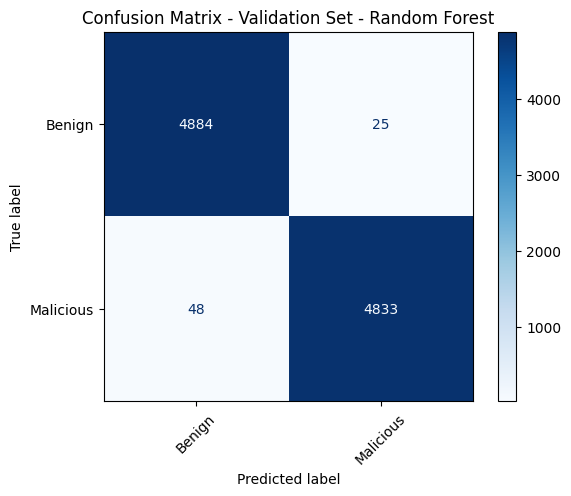

In [98]:
model,confMatrix = mlModel.rForest()
print('Model -',model)
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=['Benign', 'Malicious'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set - Random Forest')
plt.xticks(rotation=45)
plt.show()

No. of Boostings - 350
Max Depth - 5
K for K-Fold Cross Validation - 4
No. of Features to be selected out of 78 - 78
Model - XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=350, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


<Figure size 800x600 with 0 Axes>

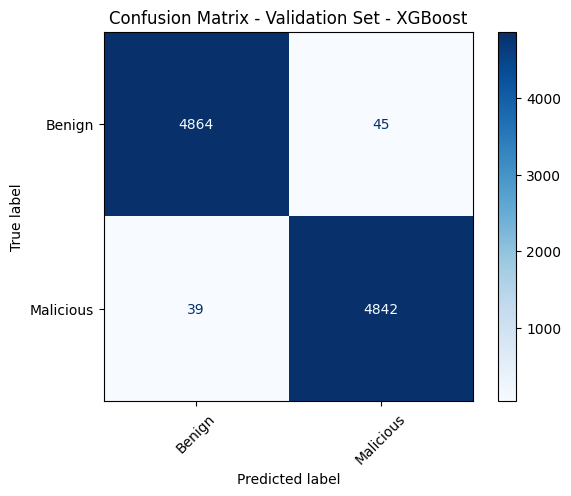

In [100]:
model,confMatrix = mlModel.xgBoost()
print('Model -',model)
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=['Benign', 'Malicious'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set - XGBoost')
plt.xticks(rotation=45)
plt.show()

No. of Boostings - 111
Max Depth - 9
K for K-Fold Cross Validation - 4
No. of Features to be selected out of 78 - 78
Model - GradientBoostingClassifier(max_depth=9, n_estimators=111, random_state=42)


<Figure size 800x600 with 0 Axes>

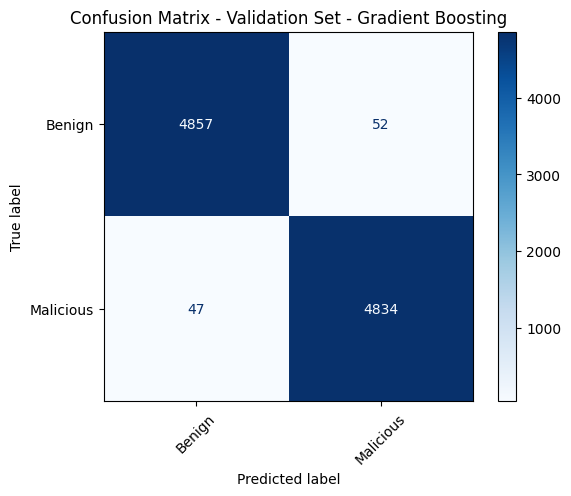

In [101]:
model,confMatrix = mlModel.gBoosting()
print('Model -',model)
disp = ConfusionMatrixDisplay(confusion_matrix=confMatrix, display_labels=['Benign', 'Malicious'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set - Gradient Boosting')
plt.xticks(rotation=45)
plt.show()

### Comparing 3 models 4 fold cross validation

|               | Random Forest | Gradient Boosting | XGBoost |
|---------------|----------|----------|----------|
|Accuracy (%)       | 99.24 % | 98.98 % | 99.14 % |
|False Positive (%) | 0.25 % | 0.53 % | 0.45 % |
              

### Now I'm trying ensembling of all 3 models
### Ensemble of 3 Models and 5 Variants of each -> Total 15 Models

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4) # 75% Train, 25% Test
conf_matrix = np.array([[0,0],[0,0]])
for ind, (train_ind, test_ind) in enumerate(kf.split(df)):
  train_df = df.iloc[train_ind, :]
  test_df = df.iloc[test_ind, :]

  # Data Splitting for train and test sets
  train_df_X = train_df.drop('target', axis=1)
  test_df_X = test_df.drop('target', axis=1)

  train_df_y = train_df['target']
  test_df_y = test_df['target']

  rf1 = RandomForestClassifier(n_estimators=51,max_depth=125)
  gb1 = GradientBoostingClassifier(n_estimators=125,max_depth=9)
  xgb1 = XGBClassifier(n_estimators=125,max_depth=5)

  rf2 = RandomForestClassifier(n_estimators=101,max_depth=175)
  gb2 = GradientBoostingClassifier(n_estimators=75,max_depth=5)
  xgb2 = XGBClassifier(n_estimators=75,max_depth=9)

  rf3 = RandomForestClassifier(n_estimators=151,max_depth=151)
  gb3 = GradientBoostingClassifier(n_estimators=51,max_depth=7)
  xgb3 = XGBClassifier(n_estimators=51,max_depth=7)

  rf4 = RandomForestClassifier(n_estimators=201,max_depth=151)
  gb4 = GradientBoostingClassifier(n_estimators=251,max_depth=7)
  xgb4 = XGBClassifier(n_estimators=251,max_depth=7)

  rf5 = RandomForestClassifier(n_estimators=251,max_depth=151)
  gb5 = GradientBoostingClassifier(n_estimators=201,max_depth=7)
  xgb5 = XGBClassifier(n_estimators=201,max_depth=7)

  rf1.fit(train_df_X,train_df_y)
  gb1.fit(train_df_X,train_df_y)
  xgb1.fit(train_df_X,train_df_y)

  rf2.fit(train_df_X,train_df_y)
  gb2.fit(train_df_X,train_df_y)
  xgb2.fit(train_df_X,train_df_y)

  rf3.fit(train_df_X,train_df_y)
  gb3.fit(train_df_X,train_df_y)
  xgb3.fit(train_df_X,train_df_y)

  rf4.fit(train_df_X,train_df_y)
  gb4.fit(train_df_X,train_df_y)
  xgb4.fit(train_df_X,train_df_y)

  rf5.fit(train_df_X,train_df_y)
  gb5.fit(train_df_X,train_df_y)
  xgb5.fit(train_df_X,train_df_y)

  rf_pred1 = rf1.predict(test_df_X)
  gb_pred1 = gb1.predict(test_df_X)
  xgb_pred1 = xgb1.predict(test_df_X)

  rf_pred2 = rf2.predict(test_df_X)
  gb_pred2 = gb2.predict(test_df_X)
  xgb_pred2 = xgb2.predict(test_df_X)

  rf_pred3 = rf3.predict(test_df_X)
  gb_pred3 = gb3.predict(test_df_X)
  xgb_pred3 = xgb3.predict(test_df_X)

  rf_pred4 = rf4.predict(test_df_X)
  gb_pred4 = gb4.predict(test_df_X)
  xgb_pred4 = xgb4.predict(test_df_X)

  rf_pred5 = rf5.predict(test_df_X)
  gb_pred5 = gb5.predict(test_df_X)
  xgb_pred5 = xgb5.predict(test_df_X)

  finalPred = []
  for i in range(len(rf_pred1)):
    c = rf_pred1[i]+gb_pred1[i]+xgb_pred1[i]+rf_pred2[i]+gb_pred2[i]+xgb_pred2[i]+rf_pred3[i]+gb_pred3[i]+xgb_pred3[i]+rf_pred4[i]+gb_pred4[i]+xgb_pred4[i]+rf_pred5[i]+gb_pred5[i]+xgb_pred5[i]
    if(c == 15):
      finalPred.append(1)
    else:
      finalPred.append(0)
  finalPred = np.array(finalPred)
  conf_matrix += confusion_matrix(test_df_y, finalPred)
conf_matrix

array([[4890,   19],
       [ 100, 4781]])

### Saving all 15 Models

In [13]:
from joblib import dump

dump(rf1, 'rf_model1.joblib')
dump(rf2, 'rf_model2.joblib')
dump(rf3, 'rf_model3.joblib')
dump(rf4, 'rf_model4.joblib')
dump(rf5, 'rf_model5.joblib')
dump(gb1, 'gb_model1.joblib')
dump(gb2, 'gb_model2.joblib')
dump(gb3, 'gb_model3.joblib')
dump(gb4, 'gb_model4.joblib')
dump(gb5, 'gb_model5.joblib')
dump(xgb1, 'xgb_model1.joblib')
dump(xgb2, 'xgb_model2.joblib')
dump(xgb3, 'xgb_model3.joblib')
dump(xgb4, 'xgb_model4.joblib')
dump(xgb5, 'xgb_model5.joblib')

['xgb_model5.joblib']

<Figure size 800x600 with 0 Axes>

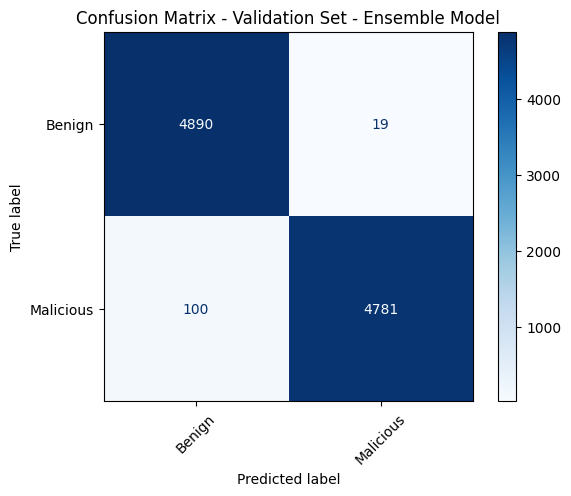

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'Malicious'])
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Set - Ensemble Model')
plt.xticks(rotation=45)
plt.show()



|               | 15 Models Combine |
|---------------|----------|
|Accuracy (%)       | 98.76 % |
|False Positive (%) | 0.18 % |
              

## ROC Curve

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

dfX = df.drop('target', axis = 1)
dfY = df['target']

rf1 = RandomForestClassifier(n_estimators=51,max_depth=125)
gb1 = GradientBoostingClassifier(n_estimators=125,max_depth=9)
xgb1 = XGBClassifier(n_estimators=125,max_depth=5)

rf2 = RandomForestClassifier(n_estimators=101,max_depth=175)
gb2 = GradientBoostingClassifier(n_estimators=75,max_depth=5)
xgb2 = XGBClassifier(n_estimators=75,max_depth=9)

rf3 = RandomForestClassifier(n_estimators=151,max_depth=151)
gb3 = GradientBoostingClassifier(n_estimators=51,max_depth=7)
xgb3 = XGBClassifier(n_estimators=51,max_depth=7)

rf4 = RandomForestClassifier(n_estimators=201,max_depth=151)
gb4 = GradientBoostingClassifier(n_estimators=251,max_depth=7)
xgb4 = XGBClassifier(n_estimators=251,max_depth=7)

rf5 = RandomForestClassifier(n_estimators=251,max_depth=151)
gb5 = GradientBoostingClassifier(n_estimators=201,max_depth=7)
xgb5 = XGBClassifier(n_estimators=201,max_depth=7)

# Create an ensemble of 15 Random Forest classifiers using 4-fold cross-validation
n_models = [rf1, rf2, rf3, rf4, rf5, gb1, gb2, gb3, gb4, gb5, xgb1, xgb2, xgb3, xgb4, xgb5]
ensemble_models = []
kf = KFold(n_splits=4, shuffle=False)  # 4-fold cross-validation

for model in n_models:
    model_probs = []  # Collect predicted probabilities for each fold

    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index,:]
        test_df = df.iloc[test_index,:]
        X_train, X_test = train_df.drop('target', axis=1), test_df.drop('target', axis=1)
        y_train, y_test = train_df['target'], test_df['target']

        model.fit(X_train, y_train)
        probs = model.predict_proba(X_test)[:, 1]
        model_probs.extend(probs)

    ensemble_models.append(model_probs)

# Calculate average probabilities across folds for each model
avg_probs = np.mean(ensemble_models, axis=0)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(dfY, avg_probs)
roc_auc = auc(fpr, tpr)

# Find threshold with low false positive rate and high true positive rate
low_fpr_threshold = thresholds[np.argmax(tpr * (1 - fpr))]

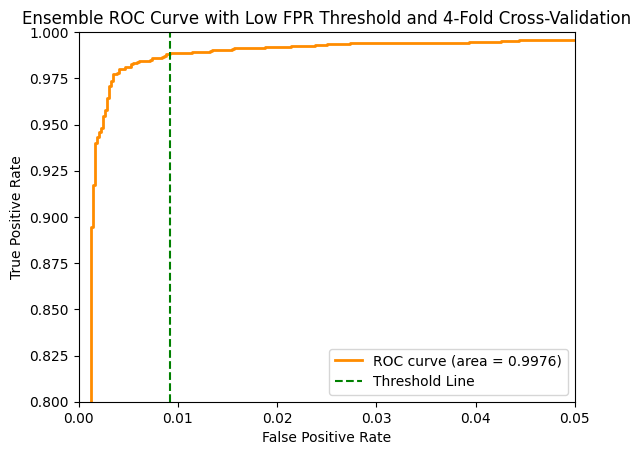

In [15]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Ensemble ROC Curve with Low FPR Threshold and 4-Fold Cross-Validation')
plt.axvline(x=fpr[np.argmax(tpr * (1 - fpr))], color='green', linestyle='--', label=f'Threshold Line ')
plt.legend(loc="lower right")
plt.xlim(0,0.05)
plt.ylim(0.8,1)
plt.show()

In [24]:
print('DR vs FP with Thresholds')
c=0
for dr, fp, thr in zip(tpr, fpr, thresholds):
  if(c%10 == 0):
    if thr > 1:
      thr = float('inf')
    print(f'{100*dr:>6.3f}%', f'{10*fp:10.4f}%', f'{thr:15.4f}')
  c+=1

DR vs FP with Thresholds
 0.000%     0.0000%             inf
 1.168%     0.0081%          0.9994
 4.466%     0.0081%          0.9994
 5.941%     0.0081%          0.9994
 7.171%     0.0081%          0.9993
 8.502%     0.0081%          0.9993
13.010%     0.0081%          0.9993
14.464%     0.0081%          0.9993
15.017%     0.0081%          0.9993
17.169%     0.0081%          0.9993
18.849%     0.0081%          0.9993
21.061%     0.0081%          0.9992
22.639%     0.0081%          0.9992
26.224%     0.0081%          0.9992
27.289%     0.0081%          0.9992
28.273%     0.0102%          0.9992
29.400%     0.0102%          0.9991
30.383%     0.0102%          0.9991
31.080%     0.0102%          0.9991
35.730%     0.0102%          0.9991
36.632%     0.0102%          0.9990
37.697%     0.0102%          0.9990
40.299%     0.0102%          0.9990
40.975%     0.0102%          0.9990
41.815%     0.0102%          0.9990
46.671%     0.0102%          0.9989
47.716%     0.0102%          0.9989
50.

In [33]:
print(f'Detection Rate at Best Threshold - {100*tpr[np.argmax(tpr * (1 - fpr))]:>6.3f}%')
print(f'False Positive at Best Threshold - {10*fpr[np.argmax(tpr * (1 - fpr))]:5.4f}%')

Detection Rate at Best Threshold - 98.853%
False Positive at Best Threshold - 0.0917%
